In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
import cv2
import numpy as np

In [3]:
import tensorflow as tf
from keras import backend as K
from pathlib import PurePath, Path

Using TensorFlow backend.


In [4]:
from detector.face_detector import FaceAlignmentDetector
from facenet.facenet_model import FaceNet
from converter.landmarks_alignment import *
from scipy.spatial import distance

In [5]:
fd = FaceAlignmentDetector(
    fd_weights_path="./detector/s3fd/s3fd_keras_weights.h5", 
    lmd_weights_path="./detector/FAN/2DFAN-4_keras.h5"
)

C:\Users\shaoa\Anaconda3\envs\tensorflow\lib\site-packages\keras\models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [6]:
#facenet = FaceNet()
facenet = FaceNet(classes=512, weights_path='./facenet/facenet/facenet_keras_weights_VGGFace2.h5')

In [7]:
K.set_learning_phase(0)

In [8]:
from utils import get_68_landmarks_edge_image

In [9]:
def get_tar_landmarks(img, landmarks_type=5):
    """    
    img: detected face image
    """         
    img_sz = img.shape
    if landmarks_type == 68:
        avg_landmarks = np.array(
            [[0.21, 0.11], [0.18, 0.17], [0.17, 0.25], [0.18, 0.32], [0.2 , 0.38], [0.2 , 0.62], [0.18, 0.67], 
             [0.17, 0.73], [0.18, 0.82], [0.21, 0.88], [0.33, 0.5 ], [0.42, 0.5 ], [0.49, 0.5 ], [0.57, 0.5 ], 
             [0.6 , 0.42], [0.61, 0.45], [0.63, 0.5 ], [0.61, 0.54], [0.6 , 0.57], [0.32, 0.22], [0.29, 0.26], 
             [0.29, 0.32], [0.32, 0.38], [0.33, 0.32], [0.33, 0.26], [0.32, 0.62], [0.29, 0.67], [0.29, 0.73], 
             [0.32, 0.78], [0.33, 0.73], [0.35, 0.67], [0.71, 0.31], [0.7 , 0.38], [0.69, 0.45], [0.7 , 0.5 ], 
             [0.69, 0.54], [0.7 , 0.63], [0.71, 0.69], [0.76, 0.62], [0.79, 0.56], [0.79, 0.5 ], [0.79, 0.44], 
             [0.76, 0.38], [0.71, 0.32], [0.73, 0.44], [0.73, 0.5 ], [0.73, 0.56], [0.71, 0.67], [0.73, 0.56], 
             [0.73, 0.5 ], [0.73, 0.44]]
        )                 
    else:
        NotImplementedError(f"Only 68 and 5 points landmarks model are provided. Received {landmarks_pnts}.")
    tar_landmarks = [(int(xy[0]*img_sz[0]), int(xy[1]*img_sz[1])) for xy in avg_landmarks]
    return tar_landmarks

In [10]:
def compute_emb_cosing_distance(im1, tar_emb=None, facenet=None):
    if tar_emb is None and facenet is None:
        return -1
    im1 = im1 / 255 * 2 - 1 # [0, 255] to [-1, +1]    
    emb1 = facenet.net.predict([im1[np.newaxis, ...]])[0]    
    return distance.cosine(emb1, tar_emb)

def compute_L2_difference(im1, tar_emb=None, facenet=None):
    if tar_emb is None and facenet is None:
        return -1
    im1 = im1 / 255 * 2 - 1 # [0, 255] to [-1, +1]    
    emb1 = facenet.net.predict([im1[np.newaxis, ...]])[0]    
    return np.sum((emb1 - tar_emb)**2)

def get_embaddings(im, facenet, fd):
    faces, lms = fd.detect_face(im, min_face_area=50*50)   
    tar_emb = None
    if len(faces) > 0:
        faces.sort(key=lambda x: x[-1])
        x0, y1, x1, y0, conf_score = faces[0]
        det_tar_face = im[int(x0):int(x1), int(y0):int(y1), :]
        
        src_landmarks = get_src_landmarks(x0, x1, y0, y1, lms[:,0:1])
        src_landmarks += np.array([[x0, y0]])
        tar_landmarks = get_tar_landmarks(im, landmarks_type=68)
        tar_landmarks += np.array([[0, 0]])
        #tar_landmarks += np.array([[x0, y0]])
        
        draw = im.copy()
        for pnt in src_landmarks:
            cv2.circle(draw, tuple(pnt[::-1].astype(np.int32)), 3, (0,255,0), -1)
        for pnt in tar_landmarks:
            cv2.circle(draw, tuple(pnt[::-1].astype(np.int32)), 3, (255,0,0), -1)
        
        draw2 = get_68_landmarks_edge_image(
            im, 
            det_tar_face, 
            lms,
            apply_dilate_or_erode=False)
        draw2 = landmarks_match(draw2, src_landmarks, tar_landmarks, border_mode=cv2.BORDER_CONSTANT, border_value=(0,0,0))

        # align detected face
        #det_tar_face = landmarks_match(det_tar_face, src_landmarks, tar_landmarks, border_mode=cv2.BORDER_CONSTANT, border_value=(0,0,0))
        im = landmarks_match(im, src_landmarks, tar_landmarks, border_mode=cv2.BORDER_CONSTANT, border_value=(0,0,0))
        #det_face2, _ = fd.detect_face(im, min_face_area=35*35)    
        #det_face2.sort(key=lambda x: x[-1])
        #x0, y1, x1, y0, conf_score = det_face2[0]
        #det_tar_face = im[int(x0):int(x1), int(y0):int(y1), :]
        det_tar_face = im
        
        tar_emb = facenet.net.predict([det_tar_face[np.newaxis, ...]/255*2-1])
    assert tar_emb is not None, "No face is detected."
    return tar_emb, det_tar_face, draw, im, draw2

def detect_and_verify(input_img, tar_emb, facenet, conf_thres=0.98, dist_thres=0.43):    
    if np.max(input_img.shape[:2]) > 1920:
        ratio = 1920 / np.max(input_img.shape[:2])
        input_img = cv2.resize(input_img, (0,0), fx=ratio, fy=ratio)
    
    # detect face
    faces, lms = fd.detect_face(input_img, min_face_area=35*35)            

    if len(faces) == 0:
        return [], 999, input_img
    
    matched_bboxes = []
    for idx, (x0, y1, x1, y0, conf_score) in enumerate(faces):
        # crop roi
        det_face_im = input_img[int(x0):int(x1),int(y0):int(y1),:]
        pnts = lms[:, idx:idx+1]
        
        src_landmarks = get_src_landmarks(x0, x1, y0, y1, pnts)
        src_landmarks += np.array([[x0, y0]])
        tar_landmarks = get_tar_landmarks(input_img, landmarks_type=68)
        tar_landmarks += np.array([[0, 0]])
        # align detected face
        #det_face_im = landmarks_match(det_face_im, src_landmarks, tar_landmarks, border_mode=cv2.BORDER_CONSTANT, border_value=(0,0,0))
        input_img = landmarks_match(input_img, src_landmarks, tar_landmarks, border_mode=cv2.BORDER_CONSTANT, border_value=(0,0,0))
        #det_face2, _ = fd.detect_face(input_img, min_face_area=35*35)
        #det_face2.sort(key=lambda x: x[-1])
        #x0, y1, x1, y0, _ = det_face2[0]
        #det_face_im = input_img[int(x0):int(x1), int(y0):int(y1), :] 
        det_face_im = input_img
        
        dist = compute_emb_cosing_distance(det_face_im, tar_emb, facenet)
        print('L2 diff.', compute_L2_difference(det_face_im, tar_emb, facenet))
        if conf_score >= conf_thres and dist <= dist_thres:
            matched_bboxes.append((x0, y1, x1, y0, conf_score))
    num_matched_faces = len(matched_bboxes)
    print(f"Found {num_matched_faces} matched faces.")
    return matched_bboxes, dist, det_face_im

# Demo

In [11]:
from matplotlib import pyplot as plt
from glob import glob

## The following cell shows the taget face.

In [12]:
test_fns1 = glob("cage_trump_dataset/trump/*.jpg")
test_fns2 = glob("cage_trump_dataset/cage/*.jpg")
test_fns3 = glob("D:/face_dataset/vggface2/train/n000380/*.jpg")
test_fns4 = glob("D:/face_dataset/vggface2/train/n000002/*.jpg")

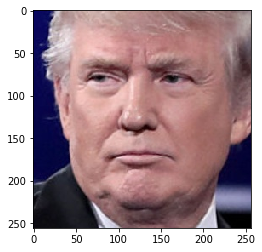

In [13]:
#im1 = cv2.imread("trn_data/trump/rgb/464669134.jpg")[..., ::-1]
np.random.seed(49)
im1 = cv2.imread(np.random.choice(test_fns1))[..., ::-1]
plt.imshow(im1)

In [14]:
# Extract embeddings
tar_emb, det_tar_face, lms, aligned_im, lms2 = get_embaddings(im1, facenet, fd)

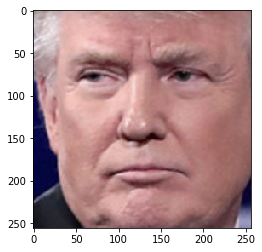

In [15]:
plt.imshow(det_tar_face)

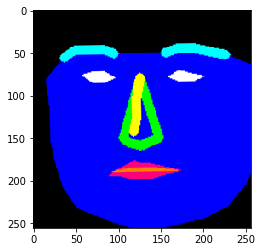

In [16]:
plt.imshow(lms2)

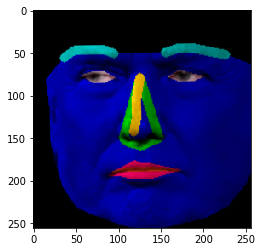

In [17]:
plt.imshow((lms2/255*det_tar_face).astype(np.uint8))

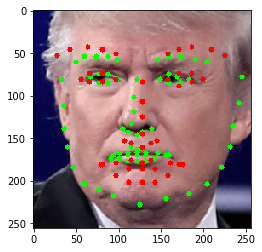

In [18]:
plt.imshow(lms)

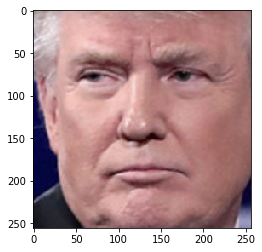

In [19]:
plt.imshow(aligned_im)

## Show random faces and treir verification results 

L2 diff. 0.8221873
Found 1 matched faces.
L2 diff. 1.2988439
Found 0 matched faces.
L2 diff. 1.5838209
Found 0 matched faces.
L2 diff. 1.4993379
Found 0 matched faces.
L2 diff. 0.61406446
Found 1 matched faces.
L2 diff. 1.4474516
Found 0 matched faces.
L2 diff. 0.37853494
Found 1 matched faces.
L2 diff. 0.42676085
Found 1 matched faces.
L2 diff. 1.7043118
Found 0 matched faces.


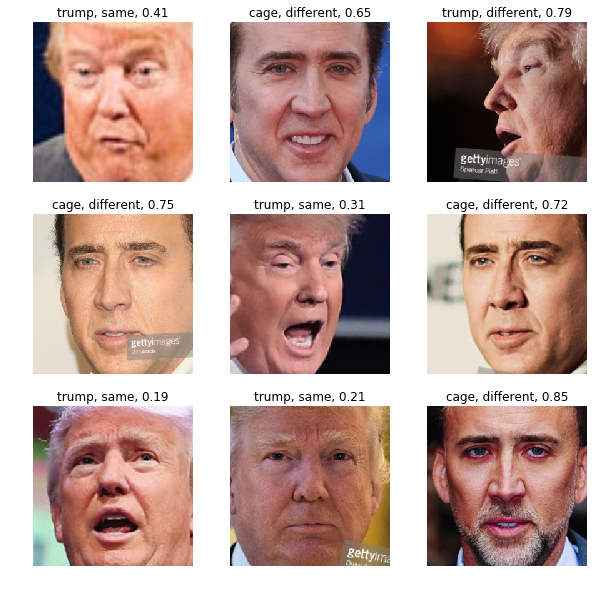

In [21]:
np.random.seed(123456)

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.axis('off')
    fn = np.random.choice(test_fns1+test_fns2)
    im2 = cv2.imread(fn)[..., ::-1]
    matched_faces, dist, det_face = detect_and_verify(im2, tar_emb, facenet, dist_thres=0.5)
    n_id = Path(fn).parts[-2]
    if len(matched_faces) >= 1:
        plt.title(f"{n_id}, same, {str(round(dist, 2))}")
    else:
        plt.title(f"{n_id}, different, {str(round(dist, 2))}")
    #plt.imshow(im2)
    plt.imshow(det_face)

L2 diff. 0.82218647
Found 1 matched faces.
L2 diff. 1.2988523
Found 0 matched faces.
L2 diff. 1.5838667
Found 0 matched faces.
L2 diff. 1.4993727
Found 0 matched faces.
L2 diff. 0.6140627
Found 1 matched faces.
L2 diff. 1.4474683
Found 0 matched faces.
L2 diff. 0.3785377
Found 1 matched faces.
L2 diff. 0.42675644
Found 1 matched faces.
L2 diff. 1.7043157
Found 0 matched faces.


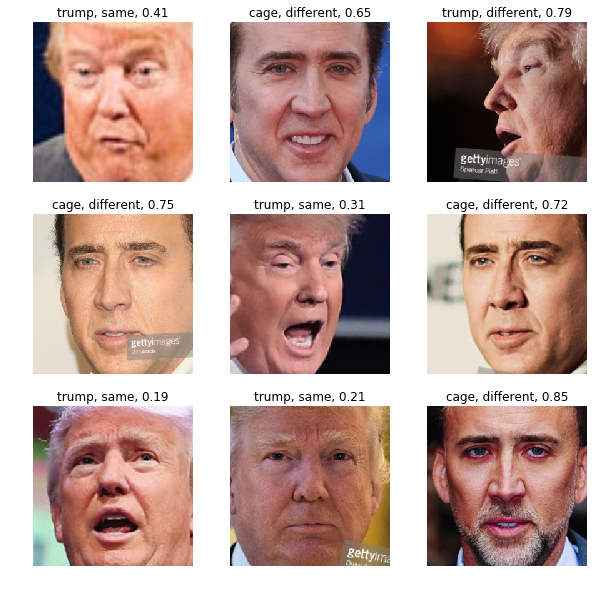

In [20]:
# facenet 
# x = K.map_fn(lambda im: tf.image.per_image_standardization(im), x)
np.random.seed(123456)

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.axis('off')
    fn = np.random.choice(test_fns1+test_fns2)
    im2 = cv2.imread(fn)[..., ::-1]
    matched_faces, dist, det_face = detect_and_verify(im2, tar_emb, facenet, dist_thres=0.5)
    n_id = Path(fn).parts[-2]
    if len(matched_faces) >= 1:
        plt.title(f"{n_id}, same, {str(round(dist, 2))}")
    else:
        plt.title(f"{n_id}, different, {str(round(dist, 2))}")
    #plt.imshow(im2)
    plt.imshow(det_face)

L2 diff. 0.5913292
Found 1 matched faces.
L2 diff. 1.333016
Found 0 matched faces.
L2 diff. 1.4206127
Found 0 matched faces.
L2 diff. 1.6748502
Found 0 matched faces.
L2 diff. 0.6249926
Found 1 matched faces.
L2 diff. 1.5232131
Found 0 matched faces.
L2 diff. 0.27868083
Found 1 matched faces.
L2 diff. 0.24637105
Found 1 matched faces.
L2 diff. 1.5242628
Found 0 matched faces.


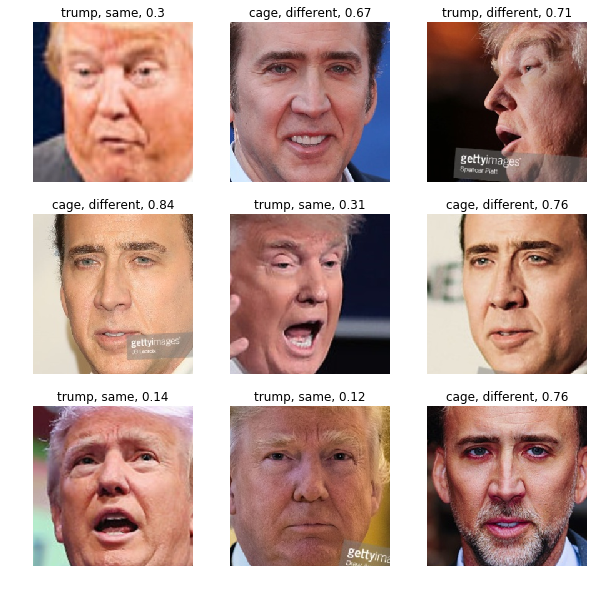

In [106]:
# orig?
np.random.seed(123456)

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.axis('off')
    fn = np.random.choice(test_fns1+test_fns2)
    im2 = cv2.imread(fn)[..., ::-1]
    matched_faces, dist, det_face = detect_and_verify(im2, tar_emb, facenet, dist_thres=0.5)
    n_id = Path(fn).parts[-2]
    if len(matched_faces) >= 1:
        plt.title(f"{n_id}, same, {str(round(dist, 2))}")
    else:
        plt.title(f"{n_id}, different, {str(round(dist, 2))}")
    #plt.imshow(im2)
    plt.imshow(det_face)

In [46]:
%debug

> <ipython-input-42-fcb84f8ebdd3>(35)compute_emb_cosing_distance()
     33     if tar_emb is None and facenet is None:
     34         return -1
---> 35     im1 = im1 / 255 * 2 - 1 # [0, 255] to [-1, +1]
     36     emb1 = facenet.net.predict([im1[np.newaxis, ...]])[0]
     37     return distance.cosine(emb1, tar_emb)

ipdb> im1
[array([ 36.        , 148.        , 220.        ,   0.        ,
         0.74490643])]
ipdb> q


In [11]:
im1 = cv2.imread("train_aligned_and_cleaned/n000006/rgb/0002_02.jpg")[...,::-1]
im2 = cv2.imread("train_aligned_and_cleaned/n000002/rgb/0006_01.jpg")[...,::-1]

In [23]:
facenet.net.predict(cv2.resize(im1, (64,64))[np.newaxis, ...]/255*2-1)

array([[ 2.14153025e-02,  4.38079946e-02, -3.99316289e-02,
        -1.83467306e-02,  1.59157906e-03, -1.34157054e-02,
         1.81668162e-04,  2.04894990e-02, -1.75003167e-02,
         2.50502080e-02,  3.74772660e-02, -7.75663406e-02,
        -1.88398231e-02, -8.58892351e-02,  1.70201510e-02,
        -1.78454332e-02,  3.08673456e-02, -3.31681105e-03,
        -5.81668541e-02, -5.43313567e-03,  9.02191736e-03,
         7.83385485e-02, -1.24678770e-02,  3.53220440e-02,
        -6.87433556e-02,  1.00928992e-01,  6.08293666e-03,
        -5.20932451e-02, -1.67299788e-02,  7.27949366e-02,
        -2.22134683e-02,  9.74052474e-02, -1.87523626e-02,
         4.30476330e-02,  3.90768610e-02, -4.59899148e-03,
         2.19581812e-03, -2.57553104e-02, -1.50855165e-02,
         5.65354675e-02,  6.08157553e-03, -3.75791043e-02,
         1.41462265e-02,  5.33535294e-02, -6.27327114e-02,
        -6.13764748e-02, -2.32081451e-02,  4.51348722e-02,
        -8.15110430e-02,  2.90173721e-02, -9.71135963e-0

In [13]:
emb1 = get_embaddings(im1, facenet, fd)
emb2 = get_embaddings(im2, facenet, fd)

In [15]:
emb1

(array([[ 4.26473618e-02,  3.03352866e-02, -8.22568759e-02,
         -5.37108583e-03, -3.30524356e-03, -2.33886801e-02,
          5.82711247e-04,  6.06203899e-02,  2.66758408e-02,
         -9.38096736e-03, -3.99724027e-04, -6.62642792e-02,
          4.44170497e-02, -8.16217810e-02,  2.05646306e-02,
          2.70579662e-02,  3.67216468e-02, -3.28255109e-02,
         -2.02798322e-02, -3.76875661e-02, -3.95685062e-02,
          1.69865154e-02, -2.21180320e-02,  9.44718421e-02,
          9.26904846e-03,  7.30090886e-02, -3.75991464e-02,
         -7.47542456e-02,  8.78355058e-04,  4.97784987e-02,
         -6.91730604e-02,  7.96890110e-02, -6.03557788e-02,
         -2.41458556e-03,  2.50538662e-02,  2.33166385e-02,
         -1.37920994e-02, -5.07936105e-02, -5.06505780e-02,
          4.81390879e-02, -2.27846671e-02,  5.30150486e-03,
          1.70284603e-03,  1.02662789e-02, -3.42696123e-02,
          1.95838157e-02, -2.23457813e-02,  4.03229222e-02,
         -2.65346076e-02,  1.95502527e-0